# 순환 신경망으로 IMDB 리뷰 분류하기

In [1]:
from keras.datasets import imdb
from sklearn.model_selection import train_test_split

(train_input,train_target),(test_input,test_target)=imdb.load_data(num_words=500)
train_input,val_input,train_target,val_target=train_test_split(train_input,train_target,test_size=0.2,random_state=42)

from keras.preprocessing.sequence import pad_sequences

train_seq=pad_sequences(train_input,maxlen=100)
val_seq=pad_sequences(val_input,maxlen=100)

In [2]:
print(train_seq.shape,train_target.shape)

(20000, 100) (20000,)


In [3]:
import torch
train_seq=torch.tensor(train_seq)
val_seq=torch.tensor(val_seq)

In [4]:
print(train_target.dtype)

int64


In [5]:
import torch
train_target=torch.tensor(train_target,dtype=torch.float32)
val_target=torch.tensor(val_target,dtype=torch.float32)

In [6]:
print(train_target.dtype)

torch.float32


In [7]:
from torch.utils.data import TensorDataset,DataLoader

train_dataset=TensorDataset(train_seq,train_target)
val_dataset=TensorDataset(val_seq,val_target)

train_loader=DataLoader(train_dataset,batch_size=64,shuffle=True)
val_loader=DataLoader(val_dataset,batch_size=64,shuffle=False)

In [8]:
import torch.nn as nn

class IMDBRnn(nn.Module):
    def __init__(self):
        super().__init__()
        self.embedding=nn.Embedding(500,16)
        self.rnn=nn.RNN(16,8,batch_first=True)
        self.dense=nn.Linear(8,1)
        self.sigmoid=nn.Sigmoid()
    def forward(self,x):
        x=self.embedding(x)
        _,hidden=self.rnn(x)
        outputs=self.dense(hidden[-1])
        return self.sigmoid(outputs)

In [9]:
model=IMDBRnn()

import torch

device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

IMDBRnn(
  (embedding): Embedding(500, 16)
  (rnn): RNN(16, 8, batch_first=True)
  (dense): Linear(in_features=8, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

In [10]:
import torch.optim as optim

criterion=nn.BCELoss()
optimizer=optim.Adam(model.parameters(),lr=2e-4)

In [11]:
train_hist=[]
val_hist=[]
patience=2
best_loss=-1
early_stopping_counter=0

epochs=100
for epoch in range(epochs):
    model.train()
    train_loss=0
    for inputs,targets in train_loader:
        inputs,targets=inputs.to(device),targets.to(device)
        optimizer.zero_grad()
        outputs=model(inputs)
        loss=criterion(outputs.squeeze(),targets)
        loss.backward()
        optimizer.step()
        train_loss+=loss.item()

    model.eval()
    val_loss=0
    with torch.no_grad():
        for inputs,targets in val_loader:
            inputs,targets=inputs.to(device),targets.to(device)
            outputs=model(inputs)
            loss=criterion(outputs.squeeze(),targets)
            val_loss+=loss.item()
    
    train_loss=train_loss/len(train_loader)
    val_loss=val_loss/len(val_loader)
    train_hist.append(train_loss)
    val_hist.append(val_loss)
    print(f'에포크:{epoch+1},',
          f'훈련 손실:{train_loss:.4f}, 검증 손실:{val_loss:.4f}')
    
    if best_loss==-1 or val_loss<best_loss:
        best_loss=val_loss
        early_stopping_counter=0
        torch.save(model.state_dict(),'best_rnn_model.pt')
    else:
        early_stopping_counter+=1
        if early_stopping_counter>=patience:
            print(f'{epoch+1}번째 에포크에서 조기 종료되었습니다.')
            break

에포크:1, 훈련 손실:0.6991, 검증 손실:0.6952
에포크:2, 훈련 손실:0.6959, 검증 손실:0.6939
에포크:3, 훈련 손실:0.6940, 검증 손실:0.6928
에포크:4, 훈련 손실:0.6926, 검증 손실:0.6921
에포크:5, 훈련 손실:0.6915, 검증 손실:0.6914
에포크:6, 훈련 손실:0.6903, 검증 손실:0.6907
에포크:7, 훈련 손실:0.6892, 검증 손실:0.6898
에포크:8, 훈련 손실:0.6879, 검증 손실:0.6889
에포크:9, 훈련 손실:0.6865, 검증 손실:0.6879
에포크:10, 훈련 손실:0.6849, 검증 손실:0.6867
에포크:11, 훈련 손실:0.6832, 검증 손실:0.6854
에포크:12, 훈련 손실:0.6813, 검증 손실:0.6842
에포크:13, 훈련 손실:0.6793, 검증 손실:0.6827
에포크:14, 훈련 손실:0.6770, 검증 손실:0.6815
에포크:15, 훈련 손실:0.6746, 검증 손실:0.6798
에포크:16, 훈련 손실:0.6718, 검증 손실:0.6772
에포크:17, 훈련 손실:0.6686, 검증 손실:0.6744
에포크:18, 훈련 손실:0.6647, 검증 손실:0.6717
에포크:19, 훈련 손실:0.6602, 검증 손실:0.6672
에포크:20, 훈련 손실:0.6552, 검증 손실:0.6646
에포크:21, 훈련 손실:0.6495, 검증 손실:0.6579
에포크:22, 훈련 손실:0.6431, 검증 손실:0.6522
에포크:23, 훈련 손실:0.6361, 검증 손실:0.6461
에포크:24, 훈련 손실:0.6289, 검증 손실:0.6416
에포크:25, 훈련 손실:0.6213, 검증 손실:0.6335
에포크:26, 훈련 손실:0.6162, 검증 손실:0.6289
에포크:27, 훈련 손실:0.6089, 검증 손실:0.6248
에포크:28, 훈련 손실:0.6022, 검증 손실:0.6285
에포크:29, 훈련 손실:0.6006, 검증 손실:0

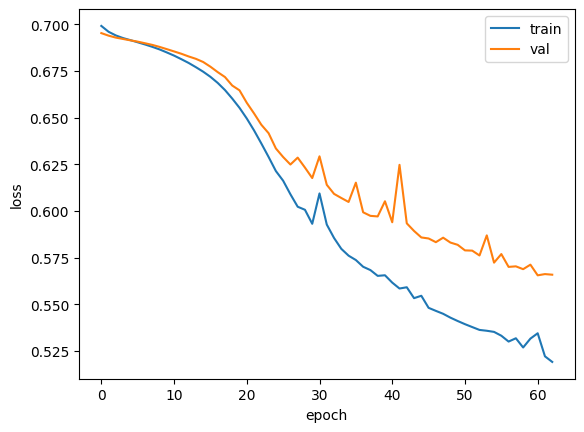

In [12]:
import matplotlib.pyplot as plt

plt.plot(train_hist,label='train')
plt.plot(val_hist,label='val')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

In [13]:
model.load_state_dict(torch.load('best_rnn_model.pt',weights_only=True))

model.eval()
corrects=0
with torch.no_grad():
    for inputs,targets in val_loader:
        inputs,targets=inputs.to(device),targets.to(device)
        outputs=model(inputs)
        predicts=outputs>0.5
        corrects+=(predicts.squeeze()==targets).sum().item()

accuracy=corrects/len(val_dataset)
print(f'검증 정확도:{accuracy:.4f}')

검증 정확도:0.7282
